# Titanic - Predictive Modelling with scikit-learn Pipelines

## Preamble

In [1]:
%matplotlib inline

In [2]:
import pandas
import seaborn
seaborn.set_style("whitegrid")
seaborn.set_palette(seaborn.color_palette("GnBu_d"))
import numpy

In [3]:
import sklearn
from sklearn import *

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/usr/local/lib/python3.6/site-pac

## Getting the Data

In [4]:
trainData = pandas.read_csv("train.csv", index_col=0)
testData = pandas.read_csv("test.csv", index_col=0)

In [5]:
responseVariable = "Survived"

In [6]:
trainData.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
testData.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
"""
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.
""";

In [9]:
XTrain = trainData.ix[:, trainData.columns.difference([responseVariable])]
yTrain = trainData.ix[:, responseVariable]
XTest = testData

## Preprocessing

### Pipeline Components for Preprocessing

In [10]:
class Categorize(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    """
    Converts given columns into pandas dtype 'category'.
    """
    
    def __init__(self, columns, encode=True):
        self.columns = columns
        self.encode = encode
    
    def fit(self, X, y):
        return self
        
    
    def transform(self, X):
        #print("categorizing columns: {0}".format(self.columns))
        for column in self.columns:
            X[column] = X[column].astype("category")
            if self.encode:
                X[column] = X[column].cat.codes
        return X

In [11]:
class AnnotateMissingValues(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    """
    For any feature that has missing values, create an extra boolean
    feature indicating whether the item has a missing values.
    """
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        nullTable = X.isnull().any()
        self.nullColumns = [column for (column, isNull) in nullTable.iteritems() if isNull]
        #print("annotating missing values for columns: {0}".format(self.nullColumns))
        for column in self.nullColumns:
            X["{0}_Missing".format(column)] = X[column].isnull()
        X = X[sorted(list(X.columns))]
        return X
    
    

In [12]:
class DropColumns(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    """
    Drops all given columns from the data frame.
    """
    
    def __init__(self, columns=[]):
        self.columns = columns
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        #print("dropping columns: {0}".format(self.columns))
        X = X.drop(self.columns, axis=1)
        return X

In [13]:
class LabelEncodeColumns(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    """
    Applies sklearn.preprocessing.LabelEncoder to multiple columns
    """
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y):
        return self
  
    def transform(self, X):
        X[self.columns] = X[self.columns].apply(sklearn.preprocessing.LabelEncoder().fit_transform)
        return X

In [40]:
class StandardScaleColumns(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    """
    TODO: work in progress
    Applies sklearn.preprocessing.StandardScaler to multiple columns of the DataFrame
    """
    
    def __init__(self, columns, dropOriginal=True):
        self.columns = columns
        self.dropOriginal = dropOriginal # drop the original columns after transformation
        
    def fit(self, X, y):
        toTransform, rest = X[self.columns],  X[X.columns.difference(self.columns)]
        toTransformArray = toTransform.as_matrix()
        self.scaler = sklearn.preprocessing.StandardScaler().fit(toTransformArray, y)
        return self
  
    def transform(self, X):
        toTransform, rest = X[self.columns],  X[X.columns.difference(self.columns)]
        transformedArray = self.scaler.transform(X.as_matrix())
        transformed = pandas.DataFrame(transformedArray, columns=columns)
        
    

In [14]:
class AsTransformer(sklearn.base.BaseEstimator):
    """
    Wrap any function in a transformer class.
    """

    def __init__(self, func):
        self._func = func

    def fit(self, *args, **kwargs):
        return self

    def transform(self, X, *args, **kwargs):
        return self._func(X, *args, **kwargs)

### Components for Feature Engineering

** extract title from name**

In [16]:
def extractTitles(X):
    X["Title"] = X["Name"].apply(lambda name: name.split(", ")[1].split(" ")[0])
    return X

## Preprocessing Pipelines

In [17]:
allColumns = XTrain.columns

In [18]:
categorial = ["Sex", 
              "Pclass",
              "Ticket", # ? can features be extracted from ticket number?
              "Embarked",
              "Cabin"
             ]

In [19]:
categorialEngineered = ["Title"]

In [20]:
numeric = ["Age",
          "SibSp",
          "Parch",
          "Fare"]

In [21]:
from sklearn.pipeline import Pipeline

In [22]:
preprocessingPipelines = {
    "numeric, imputed": Pipeline(steps = [
                                        ("drop all non-numeric", DropColumns(allColumns.difference(numeric))),
                                        ("impute missing values", sklearn.preprocessing.Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                                        ]
                                ),
    "numeric, annotated": Pipeline(steps = [
                                        ("drop all non-numeric", DropColumns(allColumns.difference(numeric))),
                                        ("annotate missing values", AnnotateMissingValues()),
                                        ("impute missing values", sklearn.preprocessing.Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                                        ]
                                ),
    "categorial, labelled": Pipeline(steps = [
                                        ("drop name", DropColumns(["Name"])),
                                        ("annotate missing values", AnnotateMissingValues()),
                                        ("strings to category labels",  Categorize(categorial)),
                                        ("impute missing values", sklearn.preprocessing.Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                                        ]
                                ),
    "with title feature": Pipeline(steps = [
                                    ("engineer title feature", AsTransformer(extractTitles)),
                                    ("drop name", DropColumns(["Name"])),
                                    ("annotate missing values", AnnotateMissingValues()),
                                    ("strings to category labels",  Categorize(categorial + ["Title"])),
                                    ("impute missing values", sklearn.preprocessing.Imputer(missing_values='NaN', strategy='most_frequent', axis=0)),
                                    ]
                            ),
}

** Preprocessing test**

In [23]:
preprocessingPipelines["with title feature"].fit(XTrain, yTrain).transform(XTrain)

array([[  22.,    0.,   -1., ...,    1.,  523.,   11.],
       [  38.,    0.,   81., ...,    1.,  596.,   12.],
       [  26.,    0.,   -1., ...,    0.,  669.,    8.],
       ..., 
       [  24.,    1.,   -1., ...,    1.,  675.,    8.],
       [  26.,    0.,   60., ...,    0.,    8.,   11.],
       [  32.,    0.,   -1., ...,    0.,  466.,   11.]])

## Prediction

### Pipeline Components for Model Selection

In [24]:
class BestByCV(sklearn.base.BaseEstimator):
    """
    Estimator which fits given collection of estimators to the data
    and then uses the one for prediction which performs best in a cross-validation.
    """
    
    
    def __init__(self, estimators, scoring, greaterIsBetter):
        self.estimators = estimators # dict: estimator name -> estimator instance
        self.scorer = sklearn.metrics.make_scorer(scoring, greater_is_better=greaterIsBetter)
        self.greaterIsBetter = greaterIsBetter
    
    def fit(self, X, y):
        # fit estimators to training set
        for (estimatorName, estimator) in self.estimators.items():
            estimator.fit(X,y)
        # run cross-validation to determine scores
        self.scores = {}
        self.meanScore = {}
        for(estimatorName, estimator) in self.estimators.items():
            self.scores[estimatorName] = model_selection.cross_val_score(estimator, X, y, scoring=self.scorer)
            self.meanScore[estimatorName] = numpy.mean(self.scores[estimatorName])
        print("mean score for models: ", self.meanScore)
        # select estimator with best score
        bestEstimatorName = max(self.meanScore, key=self.meanScore.get)
        self.bestEstimator = self.estimators[bestEstimatorName]
        print("best estimator : {0}".format(bestEstimatorName))
        return self
    
    def getRankingTable(self):
        cvScoreData = pandas.DataFrame(list(self.meanScore.items()), columns=["estimator", "score"]).sort_values(by="score", ascending=not self.greaterIsBetter)
        cvScoreData.index = range(1,len(self.meanScore) + 1)
        return cvScoreData
    
    def plotRanking(self):
        import matplotlib.pyplot as plt
        cvScores = self.getRankingTable()
        plt.figure(figsize=(14,2))
        plt.bar(cvScores.index, cvScores["score"])
        plt.xticks(cvScores.index, cvScores["estimator"], rotation=25)
        plt.suptitle("Cross Validation Scores")
        
    
    def predict(self, X):
        return self.bestEstimator.predict(X)
        

### Test Prediction

In [25]:
classifiers = {
                "Decision Tree": (tree.DecisionTreeClassifier, {}),
                "Random Forest": (ensemble.RandomForestClassifier, {}),
                "Naive Bayes": (naive_bayes.GaussianNB, {}),
                "Support Vector Machine": (svm.SVC, {}),
                "Nearest Neighbors" : (neighbors.KNeighborsClassifier, {}),
                "Gradient Boosting (sklearn)": (ensemble.GradientBoostingClassifier, {"random_state": 42}),
                "Logistic Regression" : (linear_model.logistic.LogisticRegression, {}),
                "Multilayer Perceptron" : (neural_network.MLPClassifier, {})
             }

In [26]:
def instantiate(classesAndParams):
    instances = {}
    for (name, (Class, params)) in classesAndParams.items():
        instances[name] = Class(**params)
    return instances
    

In [27]:
prepro = preprocessingPipelines["with title feature"]
model = BestByCV(instantiate(classifiers), scoring=sklearn.metrics.accuracy_score, greaterIsBetter=True)
XTrainPre = prepro.fit_transform(XTrain, yTrain)
prediction = model.fit(XTrainPre, yTrain).predict(XTrainPre)

mean score for models:  {'Decision Tree': 0.75196408529741865, 'Random Forest': 0.8136924803591471, 'Naive Bayes': 0.70145903479236804, 'Support Vector Machine': 0.63748597081930425, 'Nearest Neighbors': 0.69921436588103258, 'Gradient Boosting (sklearn)': 0.82267115600448937, 'Logistic Regression': 0.79012345679012341, 'Multilayer Perceptron': 0.73625140291806968}
best estimator : Gradient Boosting (sklearn)


In [28]:
model.getRankingTable()

,estimator,score
1,Gradient Boosting (sklearn),0.822671
2,Random Forest,0.813692
3,Logistic Regression,0.790123
4,Decision Tree,0.751964
5,Multilayer Perceptron,0.736251
6,Naive Bayes,0.701459
7,Nearest Neighbors,0.699214
8,Support Vector Machine,0.637486


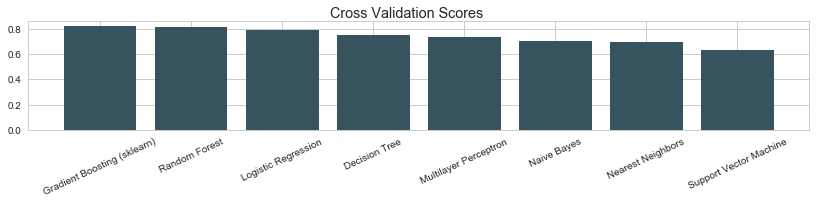

In [29]:
model.plotRanking()

## Evaluation of Pipelines

In [31]:
BestByCV()

TypeError: __init__() missing 3 required positional arguments: 'estimators', 'scoring', and 'greaterIsBetter'

## Prediction #

In [ ]:
prepro = preprocessingPipelines["categorial, labelled"]
prepro.fit(XTrain, yTrain)

In [ ]:
XTrainPre = prepro.transform(XTrain)
XTestPre = prepro.transform(XTest)

In [ ]:
predictor = BestByCV(instantiate(classifiers), scoring=sklearn.metrics.accuracy_score, greaterIsBetter=True)

In [ ]:
predictor.fit(XTrainPre, yTrain)

In [ ]:
predictor.plotRanking()

In [ ]:
predictions = predictor.predict(XTestPre)

In [ ]:
print("survival rate: {0}".format((predictions == 1).sum() / predictions.shape[0]))

## Upload

In [ ]:
submission = pandas.DataFrame({"PassengerId": testData.index, "Survived": pandas.Series(predictions)})

In [ ]:
submission.head()

In [ ]:
submission.to_csv("submission.csv", index=False)